In [1]:
# Using Base modules.
using Random
# Load a plotting library.
using Plots
# Load the distributions library.
using Distributions

using StatsPlots

# Generate Synthetic Data

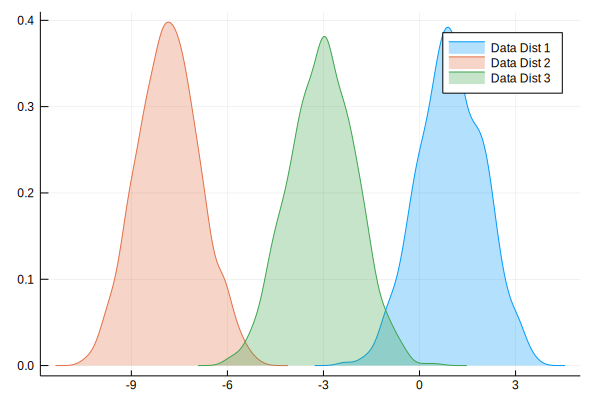

In [14]:
rng1 = RandomDevice()
rng2 = RandomDevice()
num_components = 3
mu_arr = rand(rng1, -10:2:8 , (1,num_components)) + rand(rng2, Float32, (1, num_components))
SAMPLE=1000

X = zeros(0)
for i in 1:num_components
    rng = RandomDevice()
    append!(X, randn(rng, Float32, (1, SAMPLE)) .+ mu_arr[i])
end

p = plot(X[1:SAMPLE], seriestype = :density, fill=(0, 0.3), label="Data Dist 1")
plot!(p, X[(SAMPLE+1):2SAMPLE], seriestype = :density, fill=(0, 0.3), label="Data Dist 2")
plot!(p, X[(2SAMPLE+1):3SAMPLE], seriestype = :density, fill=(0, 0.3), label="Data Dist 3")

# Model Intialization

In [15]:
function _init()
    global K=num_components
    global N=1000
    global sigma2 = 1
    rng = RandomDevice()
    global phi = rand(Dirichlet(K*N, (rand(rng, Float32,(1))*rand(rng, 1:9))[1]),(3));
    global m = rand(rng,floor(minimum(X)):floor(maximum(X)), (1,K))
    m += maximum(X)*rand(rng, Float32, (1,K))
    global s2 = rand(rng, Float32, (1, K))
    print("\nInit mean\n")
    println(m)
    print("\nInit s2\n")
    println(s2)
end

_init (generic function with 1 method)

# Define ELBO
\begin{align} ELBO \propto & \sum_j -E_q\Big[\dfrac{\mu_j}{2\sigma^2}\Big] + \sum_i\sum_j E_q\Big[c_{ij}\Big]E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] \\ &- \sum_i \sum_j E_q\Big[log~\phi_{ij}\Big] + \sum_j \dfrac{1}{2}log~(s_j^2) \end{align}

In [16]:
function get_elbo()
    t1 = log.(s2) - m./sigma2
    t1 = sum(t1)
    t2 = -0.5.*(X.^2 * ones(1, 3) + ones(3000, 1)*(s2+m.^2 ))
    t2 .+= X*m
    t2 .-= log.(phi)
    t2 .+= phi
    t2 = sum(t2)
    return t1 + t2
end

get_elbo (generic function with 1 method)

# \begin{align}  Update \phi \end{align}


 \begin{align} \dfrac{\partial}{\partial \phi_{ij}}~ELBO & \propto \dfrac{\partial}{\partial \phi_{ij}}\Big\{E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] \phi_{ij} - E_q\Big[log~\phi_{ij}\Big] \Big\}\\ & = E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] - log~\phi_{ij} - 1 = 0 \\ & E[\mu_j] = m_j \text{; } E[\mu_j^2] = V[\mu] + E^2[\mu] = s_j^2 + \mu_j^2 \\ log~\phi_{ij} & \propto E_q\Big[-\dfrac{(x_i-\mu_j)^2}{2}\Big] \\ \phi_{ij}^* & \propto exp\{ -\tfrac{1}{2}(m_j^2+s_j^2) + x_i m_j \} \end{align}

In [17]:
function _update_phi()
    t1 = X*m
    t2 = -(0.5*m.^2 + 0.5*s2)
    exponent = t1 .+ t2
    phi = exp.(exponent)
    global phi = phi ./ sum(phi,dims=2)
end

_update_phi (generic function with 1 method)

# \begin{align}  Update \mu and \sigma^2 \end{align}

\begin{align} \dfrac{\partial}{\partial m_{j}}~ELBO & \propto \dfrac{\partial}{\partial m_{j}}~\Big\{ -E\big[\dfrac{\mu_j^2}{2\sigma^2}\big] - \sum_i \phi_{ij} E[\dfrac{(x_i-\mu_j)^2}{2}] \Big\} \\ & \propto \dfrac{\partial}{\partial m_{j}}~\Big\{ -\dfrac{1}{2\sigma^2} m_j^2 - \sum_i \phi_{ij} \big[ -\dfrac{1}{2}m_j^2 + x_i m_j \big] \Big\} \\ & = -\dfrac{1}{\sigma^2}m_j - \sum_i\phi_{ij} m_j + \sum_i \phi_{ij} x_i = 0 \\ m_j^* &= \dfrac{\sum_i\phi_{ij}x_i}{\tfrac{1}{\sigma^2} + \sum_i\phi_{ij}} \end{align}

\begin{align} \dfrac{\partial}{\partial s_j^2}~ELBO & \propto \dfrac{\partial}{\partial s_j^2}~ \big\{ -E \big[\dfrac{\mu_j^2}{2\sigma^2}\big] - \sum_i \phi_{ij} E[\dfrac{(x_i-\mu_j)^2}{2}] +\dfrac{1}{2}log~s_j^2 \big\} \\ & \propto \dfrac{\partial}{\partial s_j^2}~ \Big\{ -\dfrac{1}{2\sigma^2}s_j^2 - \sum_i\phi_{ij}(\dfrac{1}{2}s_j^2) +\dfrac{1}{2}log~s_j^2 \Big\} \\ & = -\dfrac{1}{2\sigma^2} - \sum_i\dfrac{\phi_{ij}}{2} + \dfrac{1}{2s_j^2} = 0 \\ \dfrac{1}{s_j^2} & = \dfrac{1}{\sigma^2} + \sum_i\phi_{ij} \\ (s_j^2)^{*} & = \dfrac{1}{\frac{1}{\sigma^2} + \sum_i\phi_{ij}} \end{align}

In [18]:
function _update_mu()
    global m = sum((phi.*X),dims=1) .* (1 ./sigma2 .+ sum(phi,dims=1)).^(-1)
    @assert size(m)[2] == K
    #print(self.m)
    global s2 = (1 ./sigma2 .+ sum(phi,dims=1)).^(-1)
    @assert size(s2)[2] == K
end

_update_mu (generic function with 1 method)

Combine both into single Coordinate Ascent step

In [19]:
function _cavi()
    _update_phi()
    _update_mu()
end

_cavi (generic function with 1 method)

In [20]:
function fit(max_iter=100, tol=1e-20)
    _init()
    global elbo_values = [get_elbo()]
    global m_history = [m]
    global s2_history = [s2]
    for iter_ in 1:(max_iter+1)
        _cavi()
        append!(m_history, [m])
        append!(s2_history, [s2])
        append!(elbo_values, [get_elbo()])
        
        if iter_ % 5 == 0
            println(iter_, m_history[iter_])
        end
        if abs(elbo_values[end-1] - elbo_values[end]) <= tol
            i=iter_
            elbo_val = elbo_values[end]
            println("ELBO converged with $elbo_val at iteration $i")
            break
        end
        if iter_ == max_iter
            elbo_val = elbo_values[end]
            print("ELBO ended with ll $elbo_val")
        end
    end

    
end

fit (generic function with 3 methods)

In [21]:
fit()


Init mean
[3.53582 -4.39011 -6.40228]

Init s2
Float32[0.787104 0.0125035 0.586985]
5[0.974887 -3.01992 -7.81157]
10[0.970177 -3.02679 -7.81345]
15[0.970151 -3.02683 -7.81346]
20[0.970151 -3.02683 -7.81346]
25[0.970151 -3.02683 -7.81346]
30[0.970151 -3.02683 -7.81346]
35[0.970151 -3.02683 -7.81346]
ELBO converged with -1088.216745355233 at iteration 37


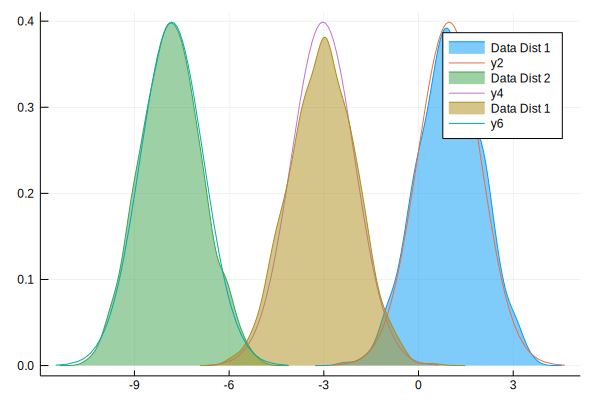

In [22]:
p = plot(X[1:SAMPLE], seriestype = :density, fill=(0, 0.5), label="Data Dist 1")
plot!(p, Normal(m[1],1),  fill=0.9)
plot!(p, X[(SAMPLE+1):2SAMPLE], seriestype = :density, fill=(0, 0.5), label="Data Dist 2")
plot!(p, Normal(m[2],1),  fill=0.9)
plot!(p, X[(2SAMPLE+1):3SAMPLE], seriestype = :density, fill=(0, 0.5), label="Data Dist 1")
plot!(p, Normal(m[3],1),  fill=0.9)

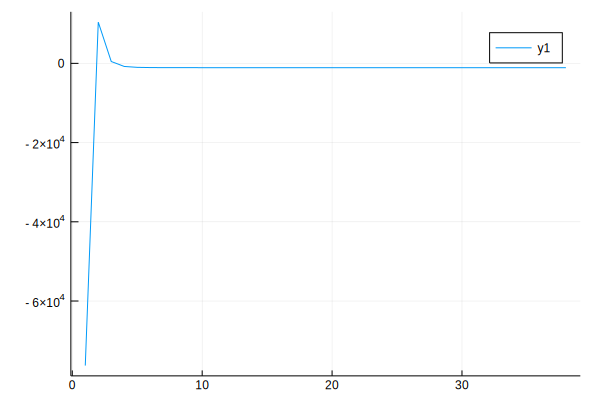

In [23]:
plot(elbo_values)

# References

- [Machine Learning: Variational Inference](https://youtu.be/2pEkWk-LHmU) by Jordan Boyd-Graber

- D. M. Blei, A. Kucukelbir, and J. D. McAuliffe, “Variational Inference: A Review for Statisticians,” J. Am. Stat. Assoc., vol. 112, no. 518, pp. 859–877, 2017.

- D. G. Tzikas, A. C. Likas and N. P. Galatsanos, “The variational approximation for Bayesian inference,” in IEEE Signal Processing Magazine, vol. 25, no. 6, pp. 131-146, November 2008. doi: 10.1109/MSP.2008.929620

- https://zhiyzuo.github.io/VI
